# Binary Classification of Machine Failures

### reference
https://www.kaggle.com/code/tetsutani/ps3e17-eda-ensemble-ml-pipeline-shap/notebook#EDA  
https://www.kaggle.com/code/manishkumar7432698/pse17-feature-engineering-tuning-optuna#Feature-Engineering

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from copy import deepcopy
from functools import partial
import random
import gc
import time
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from category_encoders import OrdinalEncoder


import optuna

import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from catboost import CatBoost, CatBoostRegressor, CatBoostClassifier
from catboost import Pool

import warnings
warnings.filterwarnings("ignore")

In [2]:
# path = '/content/drive/MyDrive/Colab Notebooks/kaggle-playground-machine/'

train=pd.read_csv('train.csv')
original=pd.read_csv("machine failure.csv")
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')


In [3]:
original.rename(columns = {'UDI':'id'}, inplace = True)

In [4]:
train=train.drop('id',axis=1)
test=test.drop('id',axis=1)
original=original.drop('id',axis=1)

## Feature Engineering


In [5]:
def create_features(df):
    # Calculate temperature difference
    df['Temperature Difference'] = df['Process temperature [K]'] - df['Air temperature [K]']

    # Calculcating Average Temperature
    df['Average Temperature'] = (df['Process temperature [K]'] + df['Air temperature [K]'])/2

    # Create a new feature by divided 'Air temperature' from 'Process temperature'
    df["Temperature ratio"] = df['Process temperature [K]'] / df['Air temperature [K]']

    # Create a new feature by multiplying 'Torque' and 'Rotational speed'
    df['Power'] = df['Torque [Nm]'] * df['Rotational speed [rpm]']

    # Eficiency Index:
    # df['Efficiency Index'] = df['Power'] / df['Tool wear [min]']

    # Create a new feature by multiplying 'Torque' by 'Tool wear'
    df['Torque * Tool wear'] = df['Torque [Nm]'] * df['Tool wear [min]']

    # Speed to Torque Ratio
    df['Rotational Speed Torque Ratio'] = df['Rotational speed [rpm]'] / df['Torque [Nm]']

    df["Failure Sum"] = (df["TWF"] +df["HDF"] +df["PWF"] +df["OSF"] +df["RNF"])

    df["Tool wear * Rotational speed"] = df["Tool wear [min]"] * df["Rotational speed [rpm]"]

    df['Tool Wear Rate'] = df['Tool wear [min]'] / df['Tool wear [min]'].max()

    # Calculate temperature change rate
    # df['TemperatureChangeRate'] = df['TemperatureDifference'] / (np.where(df['Toolwearmin']==0, 2,df['Toolwearmin']))
    # df["product_id_num"] = pd.to_numeric(df["Product ID"].str.slice(start=1))

    new_cols = [
        'Temperature Difference',
        'Average Temperature',
        'Temperature ratio',
        'Power',
        # 'Efficiency Index',
        'Torque * Tool wear',
        'Rotational Speed Torque Ratio',
        "Tool wear * Rotational speed",
        "Tool Wear Rate"
    ]

    return df, new_cols

## Label Encoding

In [7]:
def replace_Type(df):
  df["Type"] = df["Type"].replace({'L':0})
  df["Type"] = df["Type"].replace({'M':1})
  df["Type"] = df["Type"].replace({'H':2})
  df["Type"] = df["Type"].astype(int)

  return df

In [8]:
def cat_encoder(X_train, X_test, cat_cols):
  encoder = OrdinalEncoder()
  train_encoder = encoder.fit_transform(X_train[cat_cols]).astype(int)
  test_encoder = encoder.transform(X_test[cat_cols]).astype(int)
  X_train[cat_cols] = train_encoder[cat_cols]
  X_test[cat_cols] = test_encoder[cat_cols]
  return X_train,X_test

## replace outliers

In [9]:
def replace_outliers(df):
  for col in df[num_cols]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR

    df[col] = np.clip(df[col], lower-100, upper+200)
  return df

In [10]:
def rename_cols(df):
  df.rename(columns={"Process temperature [K]": "Process temperature C", "Air temperature [K]": "Air temperature C"}, inplace=True)
  df.columns = df.columns.str.replace('[\[\]]', '', regex=True)
  return df

In [11]:
num_cols = ['Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Torque [Nm]','Tool wear [min]']
cat_cols = test.select_dtypes(include=['object']).columns.tolist()

In [12]:
# Concatenate train and original dataframes, and prepare train and test sets
train = pd.concat([train, original])
test = test.copy()

In [13]:
X_train = train.drop(["Machine failure"],axis=1).reset_index(drop=True)
y_train = train["Machine failure"].reset_index(drop=True)
X_test = test.reset_index(drop=True)

# Category Encoders
X_train = replace_Type(X_train)
X_test = replace_Type(X_test)
X_train, X_test = cat_encoder(X_train, X_test, ['Product ID'])

# Create Features
X_train, _  = create_features(X_train)
X_test, new_cols  = create_features(X_test)

X_train = replace_outliers(X_train)

# StandardScaler
sc = StandardScaler()
X_train[num_cols+new_cols] = sc.fit_transform(X_train[num_cols+new_cols])
X_test[num_cols+new_cols] = sc.transform(X_test[num_cols+new_cols])

# Drop_col
drop_cols = ['RNF'] # binary_cols
X_train.drop(drop_cols, axis=1, inplace=True)
X_test.drop(drop_cols, axis=1, inplace=True)

# Rename
X_train = rename_cols(X_train)
X_test = rename_cols(X_test)

print(f"X_train shape :{X_train.shape} , y_train shape :{y_train.shape}")
print(f"X_test shape :{X_test.shape}")

X_train.head(5)

X_train shape :(146429, 20) , y_train shape :(146429,)
X_test shape :(90954, 20)


,Product ID,Type,Air temperature C,Process temperature C,Rotational speed rpm,Torque Nm,Tool wear min,TWF,HDF,PWF,OSF,Temperature Difference,Average Temperature,Temperature ratio,Power,Torque * Tool wear,Rotational Speed Torque Ratio,Failure Sum,Tool wear * Rotational speed,Tool Wear Rate
0,1,0,0.388563,-0.248148,0.579429,-0.490542,0.552766,0,0,0,0,-1.087968,0.121329,-1.068286,-0.289927,0.300523,0.200886,0,0.648061,0.552766
1,2,1,1.456753,1.547557,1.815407,-1.303478,1.491004,0,0,0,0,-0.580989,1.550436,-0.644474,-0.961066,0.575923,1.127599,0,1.944445,1.491004
2,3,0,-0.305761,-1.038258,2.164210,-1.605426,-1.245523,0,0,0,0,-0.885176,-0.640862,-0.835680,-1.311256,-1.278352,1.565177,0,-1.152848,-1.245523
3,4,0,0.602201,0.685618,0.033476,0.461755,1.444092,0,0,0,0,-0.175405,0.661214,-0.208621,0.743354,1.621112,-0.358965,0,1.423588,1.444092
4,5,1,-1.000084,-0.679117,0.920650,-0.571836,-1.104788,0,0,0,0,0.939949,-0.894926,0.963453,-0.240255,-1.083811,0.323339,0,-1.045095,-1.104788


In [14]:
class Splitter:
    def __init__(self, n_splits=5):
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        for random_state in random_state_list:
            kf = StratifiedKFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
            for train_index, val_index in kf.split(X, y):
                X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                yield X_train, X_val, y_train, y_val, val_index

## To fine-tune individual model parameters using Optuna

In [ ]:
# XGBoost 1

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, step=100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'lambda': trial.suggest_float('lambda', 1e-6, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-6, 10.0),
       'subsample': trial.suggest_float('subsample', 0.5, 1.0),
       'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
       'max_depth': trial.suggest_int('max_depth', 3, 10),
       'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
        'eta': trial.suggest_float('eta', 1e-8, 1.0),
       'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
       'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
    }

    model = xgb.XGBClassifier(random_state=42, **params)

    # Perform k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict_proba(X_val_fold)[:, 1]
        score = roc_auc_score(y_val_fold, y_val_pred)
        scores.append(score)

    avg_score = sum(scores) / len(scores)

    return avg_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print("Best params:", best_params)
print("Best ROC-AUC score:", best_score)

# Best params: {'n_estimators': 1500, 'learning_rate': 0.08901459197907591, 'booster': 'gbtree', 'lambda': 8.550251116462702, 'alpha': 6.92130114930949, 'eta': 0.7719873740829137}
# Best ROC-AUC score: 0.9719218571622437

## Define Model
LightGBM, CatBoost Xgboost and HistGradientBoosting hyper parameters are determined by optuna.

In [34]:
class Classifier:
    def __init__(self, n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.models_name = list(self._define_model().keys())
        self.len_models = len(self.models)

    def _define_model(self):

        xgb1_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.0503196477566407,
            'booster': 'gbtree',
            'lambda': 0.00379319640405843,
            'alpha': 0.106754104302093,
            'subsample': 0.938028434508189,
            'colsample_bytree': 0.212545425027345,
            'max_depth': 9,
            'min_child_weight': 2,
            'eta': 1.03662446190642E-07,
            'gamma': 0.000063826049787043,
            'grow_policy': 'lossguide',
            'n_jobs': -1,
            'objective': 'binary:logistic',
            #'eval_metric': 'auc',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        lgb1_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.0124415817896377,
            'reg_alpha': 0.00139174509988134,
            'reg_lambda': 0.000178964551019674,
            'num_leaves': 249,
            'colsample_bytree': 0.675264038614975,
            'subsample': 0.421482143660471,
            'subsample_freq': 4,
            'min_child_samples': 8,
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'is_unbalance':True,
            # 'n_jobs': -1,
            #'force_row_wise': True,
            'device': self.device,
            'random_state': self.random_state
        }
        lgb2_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.0247403801218241,
            'reg_alpha': 6.84813726047269E-06,
            'reg_lambda': 3.40443691552308E-08,
            'num_leaves': 223,
            'colsample_bytree': 0.597332047776164,
            'subsample': 0.466442641250326,
            'subsample_freq': 2,
            'min_child_samples': 5,
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'is_unbalance':True,
            # 'n_jobs': -1,
            #'force_row_wise': True,
            'device': self.device,
            'random_state': self.random_state
        }
        lgb3_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.0109757020463629,
            'reg_alpha': 0.174927073496136,
            'reg_lambda': 2.45325882544558E-07,
            'num_leaves': 235,
            'colsample_bytree': 0.756605772162953,
            'subsample': 0.703911560320816,
            'subsample_freq': 5,
            'min_child_samples': 21,
            'objective': 'binary',
            'metric': 'binary_error',
            'boosting_type': 'gbdt',
            'is_unbalance':True,
            # 'n_jobs': -1,
            #'force_row_wise': True,
            'device': self.device,
            'random_state': self.random_state
        }
        cat1_params = {
            'iterations': self.n_estimators,
            'depth': 3,
            'learning_rate': 0.020258010893459,
            'l2_leaf_reg': 0.583685138705941,
            'random_strength': 0.177768021213223,
            'od_type': "Iter",
            'od_wait': 116,
            'bootstrap_type': "Bayesian",
            'grow_policy': 'Depthwise',
            'bagging_temperature': 0.478048798393903,
            'eval_metric': 'Logloss', # AUC
            'loss_function': 'Logloss',
            'auto_class_weights': 'Balanced',
            'task_type': self.device.upper(),
            'verbose': False,
            'allow_writing_files': False,
            'random_state': self.random_state
        }
        cat2_params = {
            'iterations': self.n_estimators,
            'depth': 5,
            'learning_rate': 0.00666304601039438,
            'l2_leaf_reg': 0.0567881687170355,
            'random_strength': 0.00564702921370138,
            'od_type': "Iter",
            'od_wait': 93,
            'bootstrap_type': "Bayesian",
            'grow_policy': 'Depthwise',
            'bagging_temperature': 2.48298505165348,
            'eval_metric': 'Logloss', # AUC
            'loss_function': 'Logloss',
            'auto_class_weights': 'Balanced',
            'task_type': self.device.upper(),
            'verbose': False,
            'allow_writing_files': False,
            'random_state': self.random_state
        }
        cat3_params = {
            'iterations': self.n_estimators,
            'depth': 5,
            'learning_rate': 0.0135730417743519,
            'l2_leaf_reg': 0.0597353604503262,
            'random_strength': 0.0675876600077264,
            'od_type': "Iter",
            'od_wait': 122,
            'bootstrap_type': "Bayesian",
            'grow_policy': 'Depthwise',
            'bagging_temperature': 1.85898154006468,
            'eval_metric': 'Logloss', # AUC
            'loss_function': 'Logloss',
            'auto_class_weights': 'Balanced',
            'task_type': self.device.upper(),
            'verbose': False,
            'allow_writing_files': False,
            'random_state': self.random_state
        }
        hist_params = {
            'l2_regularization': 0.880153002159043,
            'learning_rate': 0.00251637614495506,
            'max_iter': self.n_estimators,
            'max_depth': 18,
            'max_bins': 255,
            'min_samples_leaf': 67,
            'max_leaf_nodes':66,
            'early_stopping': True,
            'n_iter_no_change': 50,
            'random_state': self.random_state
        }

        models = {
            "xgb": xgb.XGBClassifier(**xgb1_params),
            "lgb": lgb.LGBMClassifier(**lgb1_params),
            "lgb2": lgb.LGBMClassifier(**lgb2_params),
            "lgb3": lgb.LGBMClassifier(**lgb3_params),
            "cat": CatBoostClassifier(**cat1_params),
            "cat2": CatBoostClassifier(**cat2_params),
            "cat3": CatBoostClassifier(**cat3_params),
            'hgb': HistGradientBoostingClassifier(**hist_params),
            'rf': RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight="balanced", random_state=self.random_state),
            'lr': LogisticRegressionCV(max_iter=2000, random_state  =self.random_state),
        }

        return models

## Weighted Ensemble Model by Optuna on Training

In [64]:
def _objective(trial, y_true, y_preds):
    weights = [trial.suggest_float(f"weight{n}", 1e-15, 1) for n in range(len(y_preds))]  # 定義每個預測模型的權重
    weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)  # 產生加權的預測值
    score = roc_auc_score(y_true, weighted_pred)  # 計算加權預測的AUC Score
    return score

def OptunaWeights(y_true, y_preds):
    # 最佳化的過程不顯示每個trial的狀態
    optuna.logging.set_verbosity(optuna.logging.ERROR)
    # 使用 CMA-ES取樣器的Optuna取樣器實例，CMA-ES是一種進化策略演算法，通常用於連續參數的優化問題
    sampler = optuna.samplers.CmaEsSampler(seed=random_state)
    # 使用 Hyperband 演算法的 Optuna 修剪器，Hyperband 是一種基於競爭性的修剪方法，可以在較少的試驗次數下找到有潛力的參數組合，從而節省時間和資源。
    pruner = optuna.pruners.HyperbandPruner()
    study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
    objective_partial = partial(_objective, y_true=y_true, y_preds=y_preds)
    study.optimize(objective_partial, n_trials=n_trials)
    # 將找到的最佳權重儲存在 weights
    weights = [study.best_params[f"weight{n}"] for n in range(len(y_preds))]
    return weights

def weighted_predict(y_preds,weights):
    weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)
    return weighted_pred

In [69]:
%%time
n_splits = 10
random_state = 42
random_state_list = [42]
n_estimators = 9999
n_trials = 2000
device = 'cpu'
early_stopping_rounds = 200
verbose = False

# Split Data
splitter = Splitter(n_splits= n_splits)
splits = splitter.split_data(X_train, y_train, random_state_list=random_state_list)

classifier = Classifier(n_estimators=n_estimators, device=device, random_state=random_state)
test_predss = np.zeros((X_test.shape[0]))# 儲存test data的預測值
ensemble_score = []
weights = []

trained_models = {'xgb': [],'lgb': [],'lgb2': [],'lgb3': [],'cat': [],'cat2': [],'cat3': []}
score_dict = {'xgb': [],'lgb': [],'lgb2': [],'lgb3': [],'cat': [],'cat2': [],'cat3': [],'hgb': [],'rf': [], 'lr': []}

for i, (X_train_, X_val, y_train_, y_val, val_index) in enumerate(splits):
  n = i % n_splits

  # Classifier models
  classifier = Classifier(n_estimators, device, random_state)
  models = classifier.models

  # 存放每個模型的驗證與測試資料的預測值
  oof_preds = []
  test_preds = []

  # fit每一個模型
  for name, model in models.items():
      start_time = time.time()
      if 'xgb' in name: # xgboost fit 
        model.fit(X_train_, y_train_, 
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds = early_stopping_rounds, verbose=verbose)

      elif 'lgb' in name: # lgbm model fit
        model.fit(X_train_, y_train_, 
                  eval_set=[(X_val, y_val)], categorical_feature=['Type', 'Product ID'],
                  early_stopping_rounds = early_stopping_rounds, verbose=verbose)

      elif 'cat' in name : # catboost model fit
        model.fit( Pool(X_train_, y_train_,cat_features=['Type', 'Product ID']),
                  eval_set=Pool(X_val, y_val ,cat_features=['Type', 'Product ID']),
                  early_stopping_rounds = early_stopping_rounds, verbose=verbose)

      else: # LR, hgb and RF model fit
        model.fit(X_train_, y_train_)

      end_time = time.time()

      if name in trained_models.keys(): # 存放訓練好的模型，用於後續特徵重要性的輸出
          trained_models[f'{name}'].append(deepcopy(model))

      # 測試、驗證資料預測
      test_pred = model.predict_proba(X_test)[:, 1] 
      y_val_pred = model.predict_proba(X_val)[:, 1]

      score = roc_auc_score(y_val, y_val_pred) # 計算驗證資料AUC
      score_dict[name].append(score) # 存放每個模型的AUC score
      print(f'{name} [fold-{n}]  ROC-AUC score : {score:.5f} | Run Time : {int(end_time - start_time)}sec')
      # 紀錄每個模型的驗證、測試資料預測值
      oof_preds.append(y_val_pred) 
      test_preds.append(test_pred) 

  weight = OptunaWeights(y_val.values, oof_preds) # 利用每個模型的驗證資料預測值實際值，找出最佳權重

  y_val_pred = weighted_predict(oof_preds,weight) # 加權驗證資料的預測值，得出加權預測值
  score = roc_auc_score(y_val, y_val_pred) # 計算加權預測值之AUC
  print(f'Ensemble [fold-{n}] ROC-AUC score : {score:.5f} \n')
 
  ensemble_score.append(score) # 紀錄每個fold的ensemble AUC
  weights.append(weight) # 紀錄每個fold的模型權重

  # 加權測試資料的預測值，得出測試資料的加權預測值，最後將所有fold的加權預測值進行平均
  test_predss += predict(test_preds,weight) / n_splits 
  gc.collect()

xgb [fold-0]  ROC-AUC score : 0.97289 | Run Time : 32sec
lgb [fold-0]  ROC-AUC score : 0.97108 | Run Time : 3sec
lgb2 [fold-0]  ROC-AUC score : 0.96835 | Run Time : 7sec
lgb3 [fold-0]  ROC-AUC score : 0.97547 | Run Time : 2sec
cat [fold-0]  ROC-AUC score : 0.98130 | Run Time : 27sec
cat2 [fold-0]  ROC-AUC score : 0.98173 | Run Time : 74sec
cat3 [fold-0]  ROC-AUC score : 0.98174 | Run Time : 41sec
hgb [fold-0]  ROC-AUC score : 0.96715 | Run Time : 48sec
rf [fold-0]  ROC-AUC score : 0.96124 | Run Time : 20sec
lr [fold-0]  ROC-AUC score : 0.94439 | Run Time : 17sec
Ensemble [fold-0] ROC-AUC score : 0.98193 

xgb [fold-1]  ROC-AUC score : 0.96351 | Run Time : 19sec
lgb [fold-1]  ROC-AUC score : 0.96905 | Run Time : 5sec
lgb2 [fold-1]  ROC-AUC score : 0.96832 | Run Time : 8sec
lgb3 [fold-1]  ROC-AUC score : 0.97158 | Run Time : 3sec
cat [fold-1]  ROC-AUC score : 0.97521 | Run Time : 33sec
cat2 [fold-1]  ROC-AUC score : 0.97475 | Run Time : 65sec
cat3 [fold-1]  ROC-AUC score : 0.97446 | Run 

## Mean Scores for each model

In [76]:
print('--- Mean AUC Scores---')
for name, score in score_dict.items():
    mean_score = np.mean(score)
    std_score = np.std(score)
    print(f'{name}: {mean_score:.5f} ± {std_score:.5f}')

--- Mean AUC Scores---
xgb: 0.97252 ± 0.00581
lgb: 0.97583 ± 0.00530
lgb2: 0.97451 ± 0.00484
lgb3: 0.97626 ± 0.00506
cat: 0.98100 ± 0.00455
cat2: 0.98073 ± 0.00497
cat3: 0.98089 ± 0.00497
hgb: 0.96894 ± 0.00570
rf: 0.96010 ± 0.00564
lr: 0.94903 ± 0.00222


## Weight of the Optuna Ensemble

In [71]:
# Calculate the mean score of the ensemble
mean_score = np.mean(ensemble_score)
std_score = np.std(ensemble_score)
print(f'Mean Optuna Ensemble {mean_score:.5f} ± {std_score:.5f} \n')

print('--- Optuna Weights---')
mean_weights = np.mean(weights, axis=0)
std_weights = np.std(weights, axis=0)
for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
    print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')

Mean Optuna Ensemble 0.98268 ± 0.00449 

--- Optuna Weights---
xgb: 0.24189 ± 0.32163
lgb: 0.27470 ± 0.27435
lgb2: 0.36161 ± 0.41566
lgb3: 0.20895 ± 0.32763
cat: 0.17441 ± 0.28528
cat2: 0.15333 ± 0.29174
cat3: 0.15200 ± 0.29921
hgb: 0.13489 ± 0.23044
rf: 0.10121 ± 0.27349
lr: 0.36797 ± 0.40205


## Feature importance Visualization

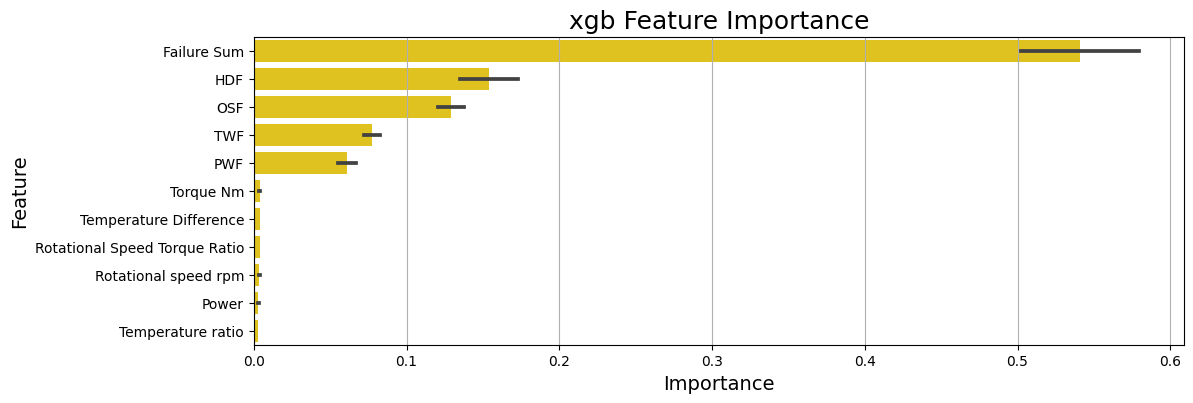

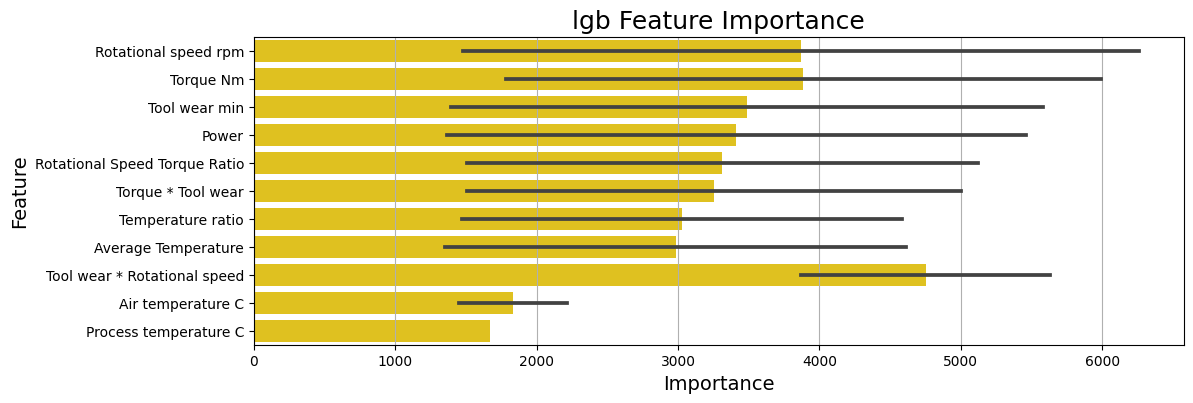

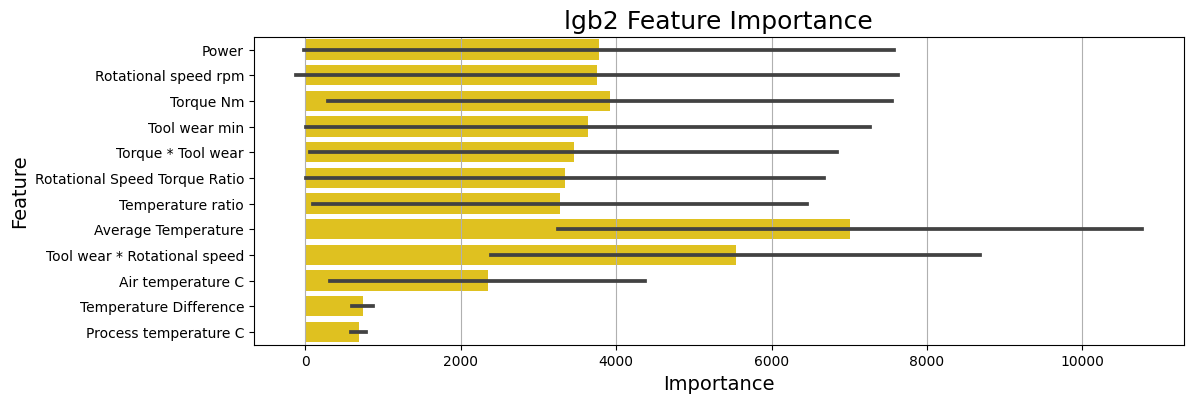

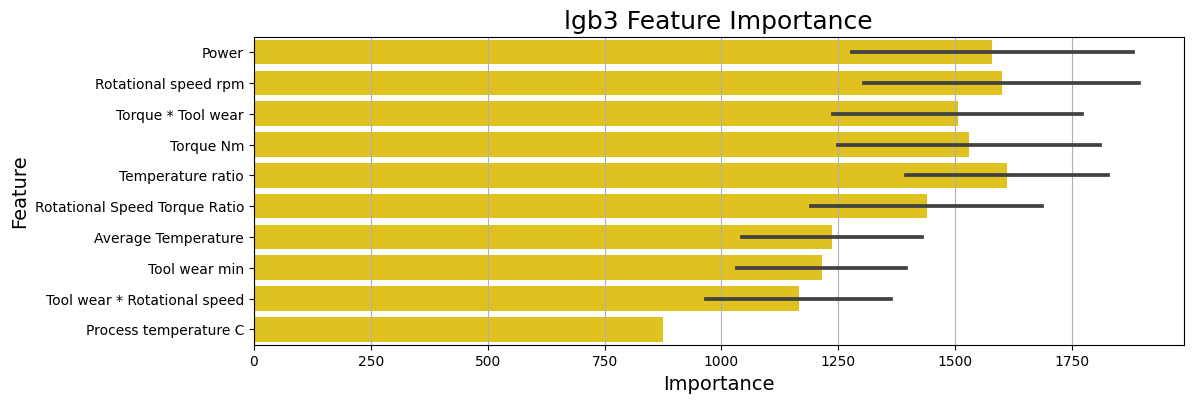

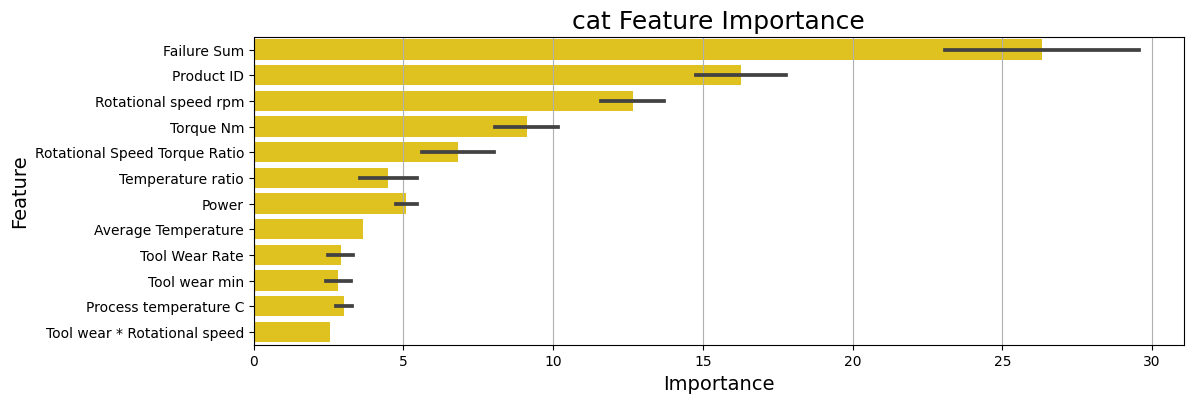

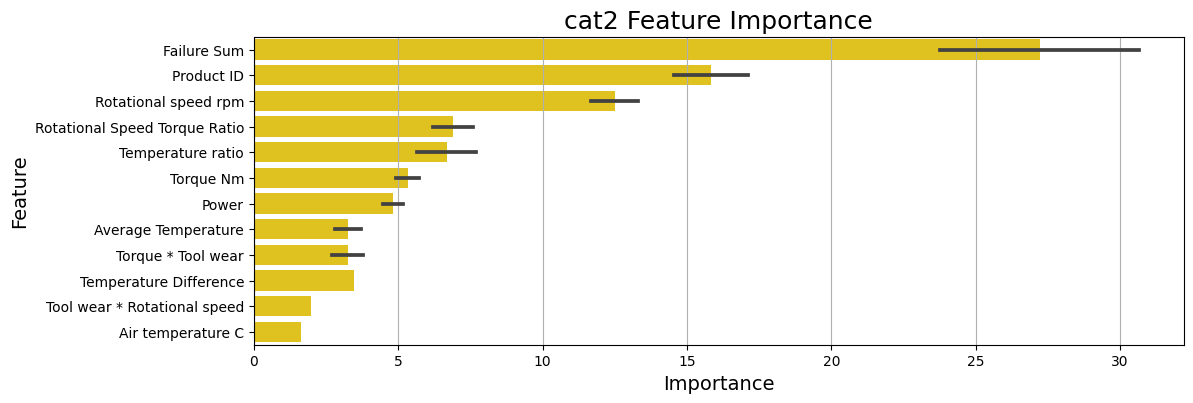

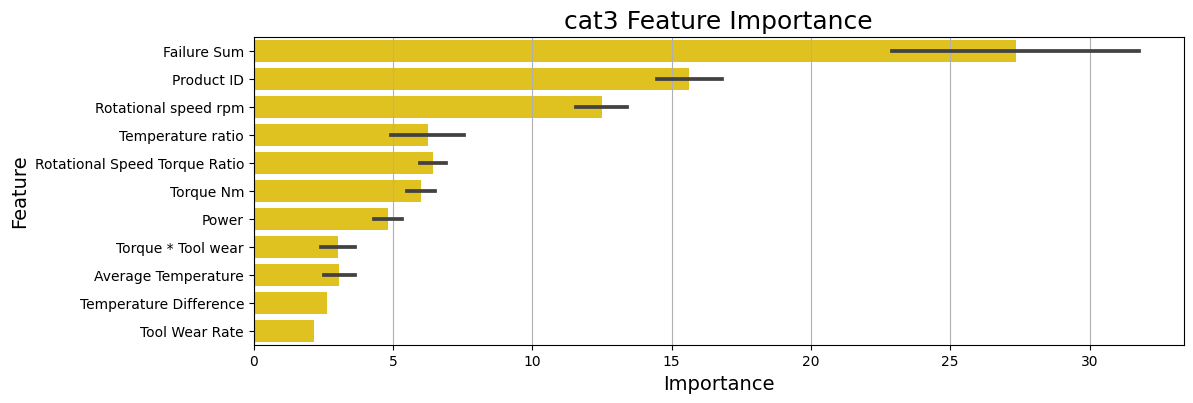

In [72]:
def visualize_importance(models, feature_cols, title, top=9):
    importances = []
    feature_importance = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df["importance"] = model.feature_importances_
        _df["feature"] = pd.Series(feature_cols)
        _df["fold"] = i
        _df = _df.sort_values('importance', ascending=False)
        _df = _df.head(top)
        feature_importance = pd.concat([feature_importance, _df], axis=0, ignore_index=True)

    feature_importance = feature_importance.sort_values('importance', ascending=False)
    # display(feature_importance.groupby(["feature"]).mean().reset_index().drop('fold', axis=1))
    plt.figure(figsize=(12, 4))
    sns.barplot(x='importance', y='feature', data=feature_importance, color='gold', errorbar='sd')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'{title} Feature Importance', fontsize=18)
    plt.grid(True, axis='x')
    plt.show()

for name, models in trained_models.items():
    if name in list(trained_models.keys()):
        visualize_importance(models, list(X_train.columns), name)

In [74]:
submission["Machine failure"] = test_predss
submission.to_csv('submission.csv', index=False)
submission

,id,Machine failure
0,136429,0.007171
1,136430,0.014158
2,136431,0.006710
3,136432,0.009803
4,136433,0.008017
...,...,...
90949,227378,0.008442
90950,227379,0.020289
90951,227380,0.007868
90952,227381,0.036488
